In [5]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [8]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = listdir_nohidden(data_dir)
    for fold in folds:
        fold_path = os.path.join(data_dir, fold)
        files = listdir_nohidden(fold_path)
        for file in files:
            fpath = os.path.join(fold_path, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat = df['labels']
    train_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123, stratify= strat)
 
    return train_df, test_df

In [45]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = listdir_nohidden(data_dir)
    for fold in folds:
        fold_path = os.path.join(data_dir, fold)
        files = listdir_nohidden(fold_path)
        for file in files:
            fpath = os.path.join(fold_path, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat = df['labels']
    train_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123, stratify= strat)
 
    return train_df, test_df

In [9]:
data_dir = 'Data/bone_marrow_cell_dataset'
train_df, test_df = create_df(data_dir)

In [10]:
train_df.head()

,filepaths,labels
137194,Data/bone_marrow_cell_dataset/NGS/NGS_08972.jpg,NGS
68587,Data/bone_marrow_cell_dataset/EBO/EBO_18417.jpg,EBO
92767,Data/bone_marrow_cell_dataset/BLA/BLA_10116.jpg,BLA
20834,Data/bone_marrow_cell_dataset/ART/ART_13016.jpg,ART
68868,Data/bone_marrow_cell_dataset/EBO/EBO_19251.jpg,EBO


In [11]:
print(len(train_df['labels'].unique()))

14


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_gens(train_df, test_df):
    img_size = (250, 250)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    batch_size = 40
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, test_gen

In [13]:
train_gen, test_gen = create_gens(train_df, test_df)

Found 153052 validated image filenames belonging to 14 classes.
Found 17006 validated image filenames belonging to 14 classes.


In [51]:
train_gen

In [52]:
num_classes = 14

In [53]:
classifier_cnn = tf.keras.Sequential([
    # first conv
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.3),
    # second conv
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    # second conv
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    # ----
    tf.keras.layers.Flatten(),
    # dense layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    # classifier
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [54]:
classifier_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [55]:
classifier_cnn.fit_generator(train_gen,
                         steps_per_epoch = 50,
                         epochs = 10,
                         validation_data = test_gen,
                         validation_steps = 500)

Epoch 1/10


/var/folders/5g/b5hghd9x6gq7f3qsrm03q_r80000gn/T/ipykernel_90386/35442443.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  classifier_cnn.fit_generator(train_gen,


50/50 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.2370

KeyboardInterrupt: 

Validation accuracy reaches about 61% with 25 epochs.

There is a few corrupted files/ known issue with openCV that made it impossible to run evaluate. Going to change train/test datasets.

 599/5669 [==>...........................] - ETA: 44s - loss: 0.1569 - accuracy: 0.5415

2022-12-10 12:32:24.145525: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: TypeError: float() argument must be a string or a number, not 'JpegImageFile'
Traceback (most recent call last):

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/keras/engine/data_adapter.py", line

InvalidArgumentError: Graph execution error:

TypeError: float() argument must be a string or a number, not 'JpegImageFile'
Traceback (most recent call last):

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/keras_preprocessing/image/iterator.py", line 231, in _get_batches_of_transformed_samples
    x = img_to_array(img, data_format=self.data_format)

  File "/Users/emmanuelpeters/miniforge3/lib/python3.9/site-packages/keras_preprocessing/image/utils.py", line 309, in img_to_array
    x = np.asarray(img, dtype=dtype)

TypeError: float() argument must be a string or a number, not 'JpegImageFile'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_2674]

In [56]:
import cv2 as cv
import glob


file_paths = test_df['filepaths']
for file_path in file_paths:
    try:
        img = cv.imread(file_path)
    except:
        print(file_path)

Couldn't fix it with code, used https://github.com/coderslagoon/BadPeggy to clean up data.

In [ ]:

from PIL import Image

num_skipped = 0

folder_path = test_df['filepaths']
for fpath in folder_path:
    try:
        img = Image.open(fpath) # open the image file
        #print("%s", fpath)
        exif_data = img._getexif()
        img.verify() # verify that it is, in fact an image
    except:
        num_skipped += 1
        # Delete corrupted image
        os.remove(fpath)
print("PIL deleted %d images" % num_skipped)

PIL deleted 0 images


In [57]:
img_size = (250, 250)
def scalar(img):
        return img
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False)

Found 17006 validated image filenames belonging to 14 classes.


In [58]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= 'Data/bone_marrow_cell_dataset/',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=img_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = 'Data/bone_marrow_cell_dataset/',
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1337,
    image_size=img_size,
)

Found 170058 files belonging to 14 classes.
Using 136047 files for training.
Found 170058 files belonging to 14 classes.
Using 34011 files for validation.


In [59]:
classifier_cnn.fit(train_ds,
                         steps_per_epoch = 50,
                         epochs = 10,
                         validation_data = val_ds,
                         validation_steps = 500)

Epoch 1/10
50/50 [==============================] - 23s 462ms/step - loss: 0.2143 - accuracy: 0.3269 - val_loss: 0.2278 - val_accuracy: 0.3124
Epoch 2/10
50/50 [==============================] - 23s 458ms/step - loss: 0.1959 - accuracy: 0.4075 - val_loss: 0.2043 - val_accuracy: 0.3738
Epoch 3/10
50/50 [==============================] - 24s 482ms/step - loss: 0.1880 - accuracy: 0.4363 - val_loss: 0.2568 - val_accuracy: 0.2718
Epoch 4/10
50/50 [==============================] - 26s 533ms/step - loss: 0.1809 - accuracy: 0.4550 - val_loss: 0.1883 - val_accuracy: 0.4366
Epoch 5/10
50/50 [==============================] - 25s 503ms/step - loss: 0.1737 - accuracy: 0.4875 - val_loss: 0.2017 - val_accuracy: 0.4267
Epoch 6/10
50/50 [==============================] - 25s 508ms/step - loss: 0.1714 - accuracy: 0.4888 - val_loss: 0.2479 - val_accuracy: 0.3140
Epoch 7/10
50/50 [==============================] - 25s 516ms/step - loss: 0.1638 - accuracy: 0.5175 - val_loss: 0.2121 - val_accuracy: 0.4354

In [ ]:
num_skipped = 0

for fname in test_df['filepaths']:
    fpath = fname
    try:
        fobj = open(fpath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
        fobj.close()

    if not is_jfif:
        num_skipped += 1
        print("delete")
        # Delete corrupted image
        os.remove(fpath)

In [75]:
y_pred = classifier_cnn.predict(val_ds)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [67]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

In [80]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = y_true.argmax(axis=-1)


In [81]:
y_pred = y_pred.argmax(axis=-1)


In [85]:
print(np.unique(y_pred))

[ 0  1  2  3  4  7  8  9 11 12 13]


In [86]:
print(np.unique(y_true))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [91]:
classifier_cnn.evaluate(val_ds)

1063/1063 [==============================] - 39s 37ms/step - loss: 0.2178 - accuracy: 0.3926


[0.21776337921619415, 0.39260828495025635]

In [92]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(250, 250, 3),
    include_top=False)

83697664/83683744 [==============================] - 3s 0us/step


In [102]:
classifier_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, None, None, 64)    1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, None, None, 64)   256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, None, None, 64)    0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 64)  

 # first conv
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.3),
    # second conv
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    # second conv
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    # ----
    tf.keras.layers.Flatten(),
    # dense layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    # classifier
    tf.keras.layers.Dense(num_classes, activation='softmax'),

In [109]:
base_model.trainable = False

In [110]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [111]:
inputs = tf.keras.Input(shape=(250, 250, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3,  activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.3)(x)
# second conv
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.1)(x)
# second conv
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.1)(x)
# ----
x = tf.keras.layers.Flatten()(x)
# dense layers
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# classifier
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
new_model = tf.keras.Model(inputs, outputs)

In [112]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 64)          1179712   
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 4, 4, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 4, 4, 64)          0   

In [113]:
new_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [114]:
new_model.fit(train_ds, validation_data=val_ds)

3653/4252 [========================>.....] - ETA: 13:48 - loss: 0.1899 - accuracy: 0.4141

KeyboardInterrupt: 

In [1]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [3]:
import time

In [14]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [15]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

Found 153052 validated image filenames belonging to 14 classes.
Found 17006 validated image filenames belonging to 14 classes.


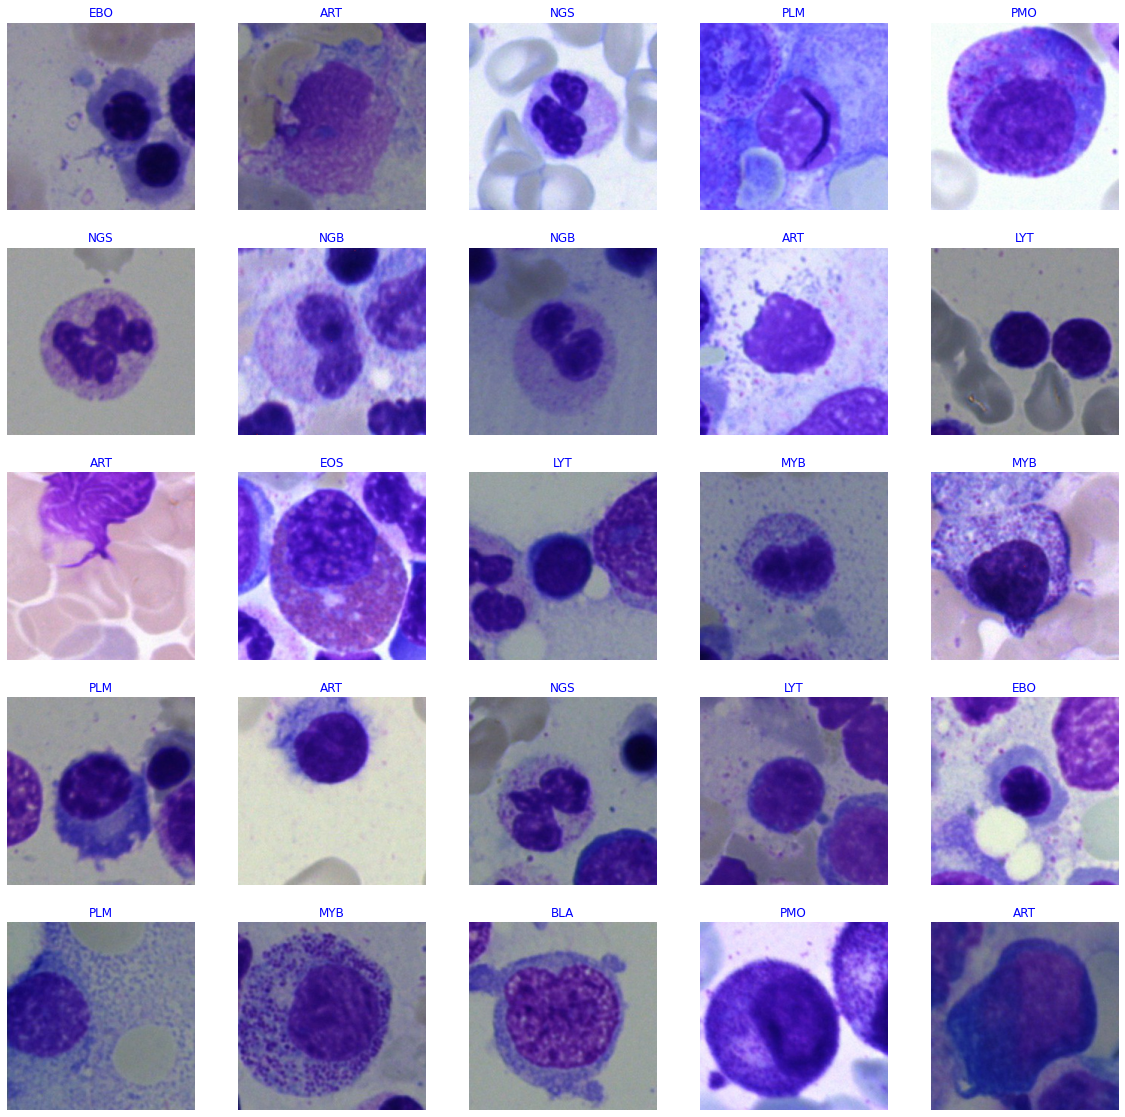

In [16]:
train_gen, test_gen = create_gens(train_df, test_df)

show_images(train_gen)

In [19]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    tf.keras.layers.Dense(256, kernel_regularizer= tf.keras.regularizers.l2(l= 0.016), activity_regularizer= tf.keras.regularizers.l1(0.006),
                bias_regularizer= tf.keras.regularizers.l1(0.006), activation= 'relu'),
    tf.keras.layers.Dropout(rate= 0.45, seed= 123),
    tf.keras.layers.Dense(class_count, activation= 'softmax')
])

model.compile(tf.keras.optimizers.Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 29,049,861
Trainable params: 28,873,022
Non-trainable params: 176,839
______________________________________

In [20]:
batch_size = 40
epochs = 40
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

In [21]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= test_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


2022-12-11 20:14:58.449014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


KeyboardInterrupt: 